In [2]:
# Code for: <Add description here>
%load_ext autoreload
%autoreload 2
import cmcrameri.cm as cm  # Importing the cmcrameri colormaps
%run ct_data.py '../crunchtope_model/hydrothermal_crunch.nc' -c volume

for cat in ct_data.keys():
    ct_data[cat] = ct_data[cat].rename_dims({"file_num": "file_number"})


%run pf_data.py '../pflotran_model/hydrothermal.nc'

Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite',

In [3]:
#Parameters
time = 1000

In [4]:
# Code for: <Add description here>
import matplotlib.pyplot as plt
from itertools import cycle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as is_ax

# Define a function for a custom color cycler
def custom_color_cycler():
   # Define a function for a custom Futurist-inspired color cycler
    colors = {
        'Magnesium': '#3498DB',   # Dark steel blue, dignified and cool
        'Sulfate': '#F1C40F',     # Dark, bold red with a lot of presence
        'Calcium': '#2ECC71',     # Dark jade green, distinct and elegant
        'Carbonate': '#E74C3C'    # Dark amethyst, standing apart with a creative, luxurious tone
    }
    
    # Create a color cycle
    return cycle([colors['Magnesium'], colors['Sulfate'], colors['Calcium'], colors['Carbonate']])


def plot_flux(ax, inset_ax, concentrations, data, plot_var,range_sets, legend_entries, crunchtope=False, linestyle='-'):
    """
    plot_flux: <Add description of function>
    """
    if crunchtope:
        dims = ['X', 'Y', 'Z']
        time=500
    else:
        dims = ['x', 'y', 'z']
        time=1000
    
    custom_cycler = custom_color_cycler()

    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).mean(dim=dims)
        if plot_var == 'Anhydrite_VF' or plot_var == 'Anhydrite':
            # Scale up by volume
            extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).sum(dim=dims)
            volume = extracted_data.to_numpy() * 46.9 * 46.9 * 100 # m^3
            moles = volume_to_moles(volume, molar_volume)
            if crunchtope:
                flux = moles / time * 65000e3 / 100 / 1e12 * 32# tmol/yr
            else:
                flux = moles / time * 65000e3 / 100 / 1e12 # tmol/yr
            extracted_data = flux
        
        if legend_entry == 'HCO$\mathbf{_3^-}$':
            color = next(custom_cycler)
            inset_ax.plot(conc_range, extracted_data, label=legend_entry, color=color, linestyle=linestyle)
            ax.plot([], [], label=legend_entry, color=color, linestyle=linestyle)
        else:
            ax.plot(conc_range, extracted_data, label=legend_entry, color=next(custom_cycler), linestyle=linestyle)
        print(f'For {legend_entry}, the values are {extracted_data}')

In [5]:
def anhydrite_depth(data, crunchtope=False):
    if crunchtope:
        dims = ['X', 'Y', 'Z']
        time=500
        plot_var = 'Anhydrite'
        temperature = np.loadtxt('../crunchtope_model/on_axis_temp.txt')[0:100]
    else:
        dims = ['x', 'y', 'z']
        time=1000
        plot_var = 'Anhydrite_VF'
    # First, create a DataArray for depth, assuming `y` represents depth below seafloor
    depth = 1500 - data[dims[2]]

    mineral_data = data[plot_var].sel(time=time)

    if crunchtope:
        weighted_depth = mineral_data * xr.DataArray(temperature, dims='X')
    else:
        weighted_depth = data['Temperature'].sel(time=time) * mineral_data

    # Sum the weighted depth and the total mineral amount
    total_weighted_depth = weighted_depth.sum(dim=dims)
    total_mineral_amount = mineral_data.sum(dim=dims)

    # Calculate the average depth weighted by the amount of mineral
    average_depth = total_weighted_depth / total_mineral_amount

    # Extract the average value (as it may return a DataArray)
    average_depth_value = average_depth.to_numpy()

    return average_depth_value

In [6]:
# Code for: <Add description here>

def total_volume(data, mineral, crunchtope=False):
    """
    total_volume: <Add description of function>
    """
    if crunchtope:
        dims = ['X', 'Y', 'Z']
    else:
        dims = ['x', 'y', 'z']
    # Sum variables over all coordinates and select the final time 
    total_vf = data.sum(dim=dims).sel(time=500)[mineral].to_numpy()
    total_volume = total_vf * 46.9 * 46.9 * 100 # m^3 

    return total_volume

def volume_to_moles(volume, molar_volume):
    """
    volume_to_moles: <Add description of function>
    """
    moles = volume / molar_volume
    return moles

molar_volume = 46.01 * (0.01 ** 3) # cm3/mol

vol = total_volume(pf_data, "Anhydrite_VF")
moles = volume_to_moles(vol, molar_volume)
flux = moles / time *65000e3 /100 /1e12
#s_moles_to_flux(moles) / 100

For SO$\mathbf{_4^{2-}}$, the values are [0.03814656 0.13519814 0.22165878 0.28798424 0.38101966]
For HCO$\mathbf{_3^-}$, the values are [0.2880507  0.28782794 0.28760396 0.28737739 0.28714827]
For Ca$\mathbf{^{2+}}$, the values are [0.28798424 0.32887082 0.36398828 0.36872505]
For Mg$\mathbf{^{2+}}$, the values are [0.28355156 0.28472796 0.28606626 0.28714127 0.28798424 0.28819807]
For SO$\mathbf{_4^{2-}}$, the values are [559.96006624 224.69295003 210.7241467  219.97091777 257.4456257 ]
For Ca$\mathbf{^{2+}}$, the values are [219.97091777 145.66422228  98.47454157  90.85195802]
For Mg$\mathbf{^{2+}}$, the values are [301.86264357 279.82371008 257.2025591  238.3320412  219.97091777
 216.93846929]


/var/folders/86/d5n0l2wj5yn0p84q_4jzm_6r0000gn/T/ipykernel_49167/3002153859.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/86/d5n0l2wj5yn0p84q_4jzm_6r0000gn/T/ipykernel_49167/3002153859.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


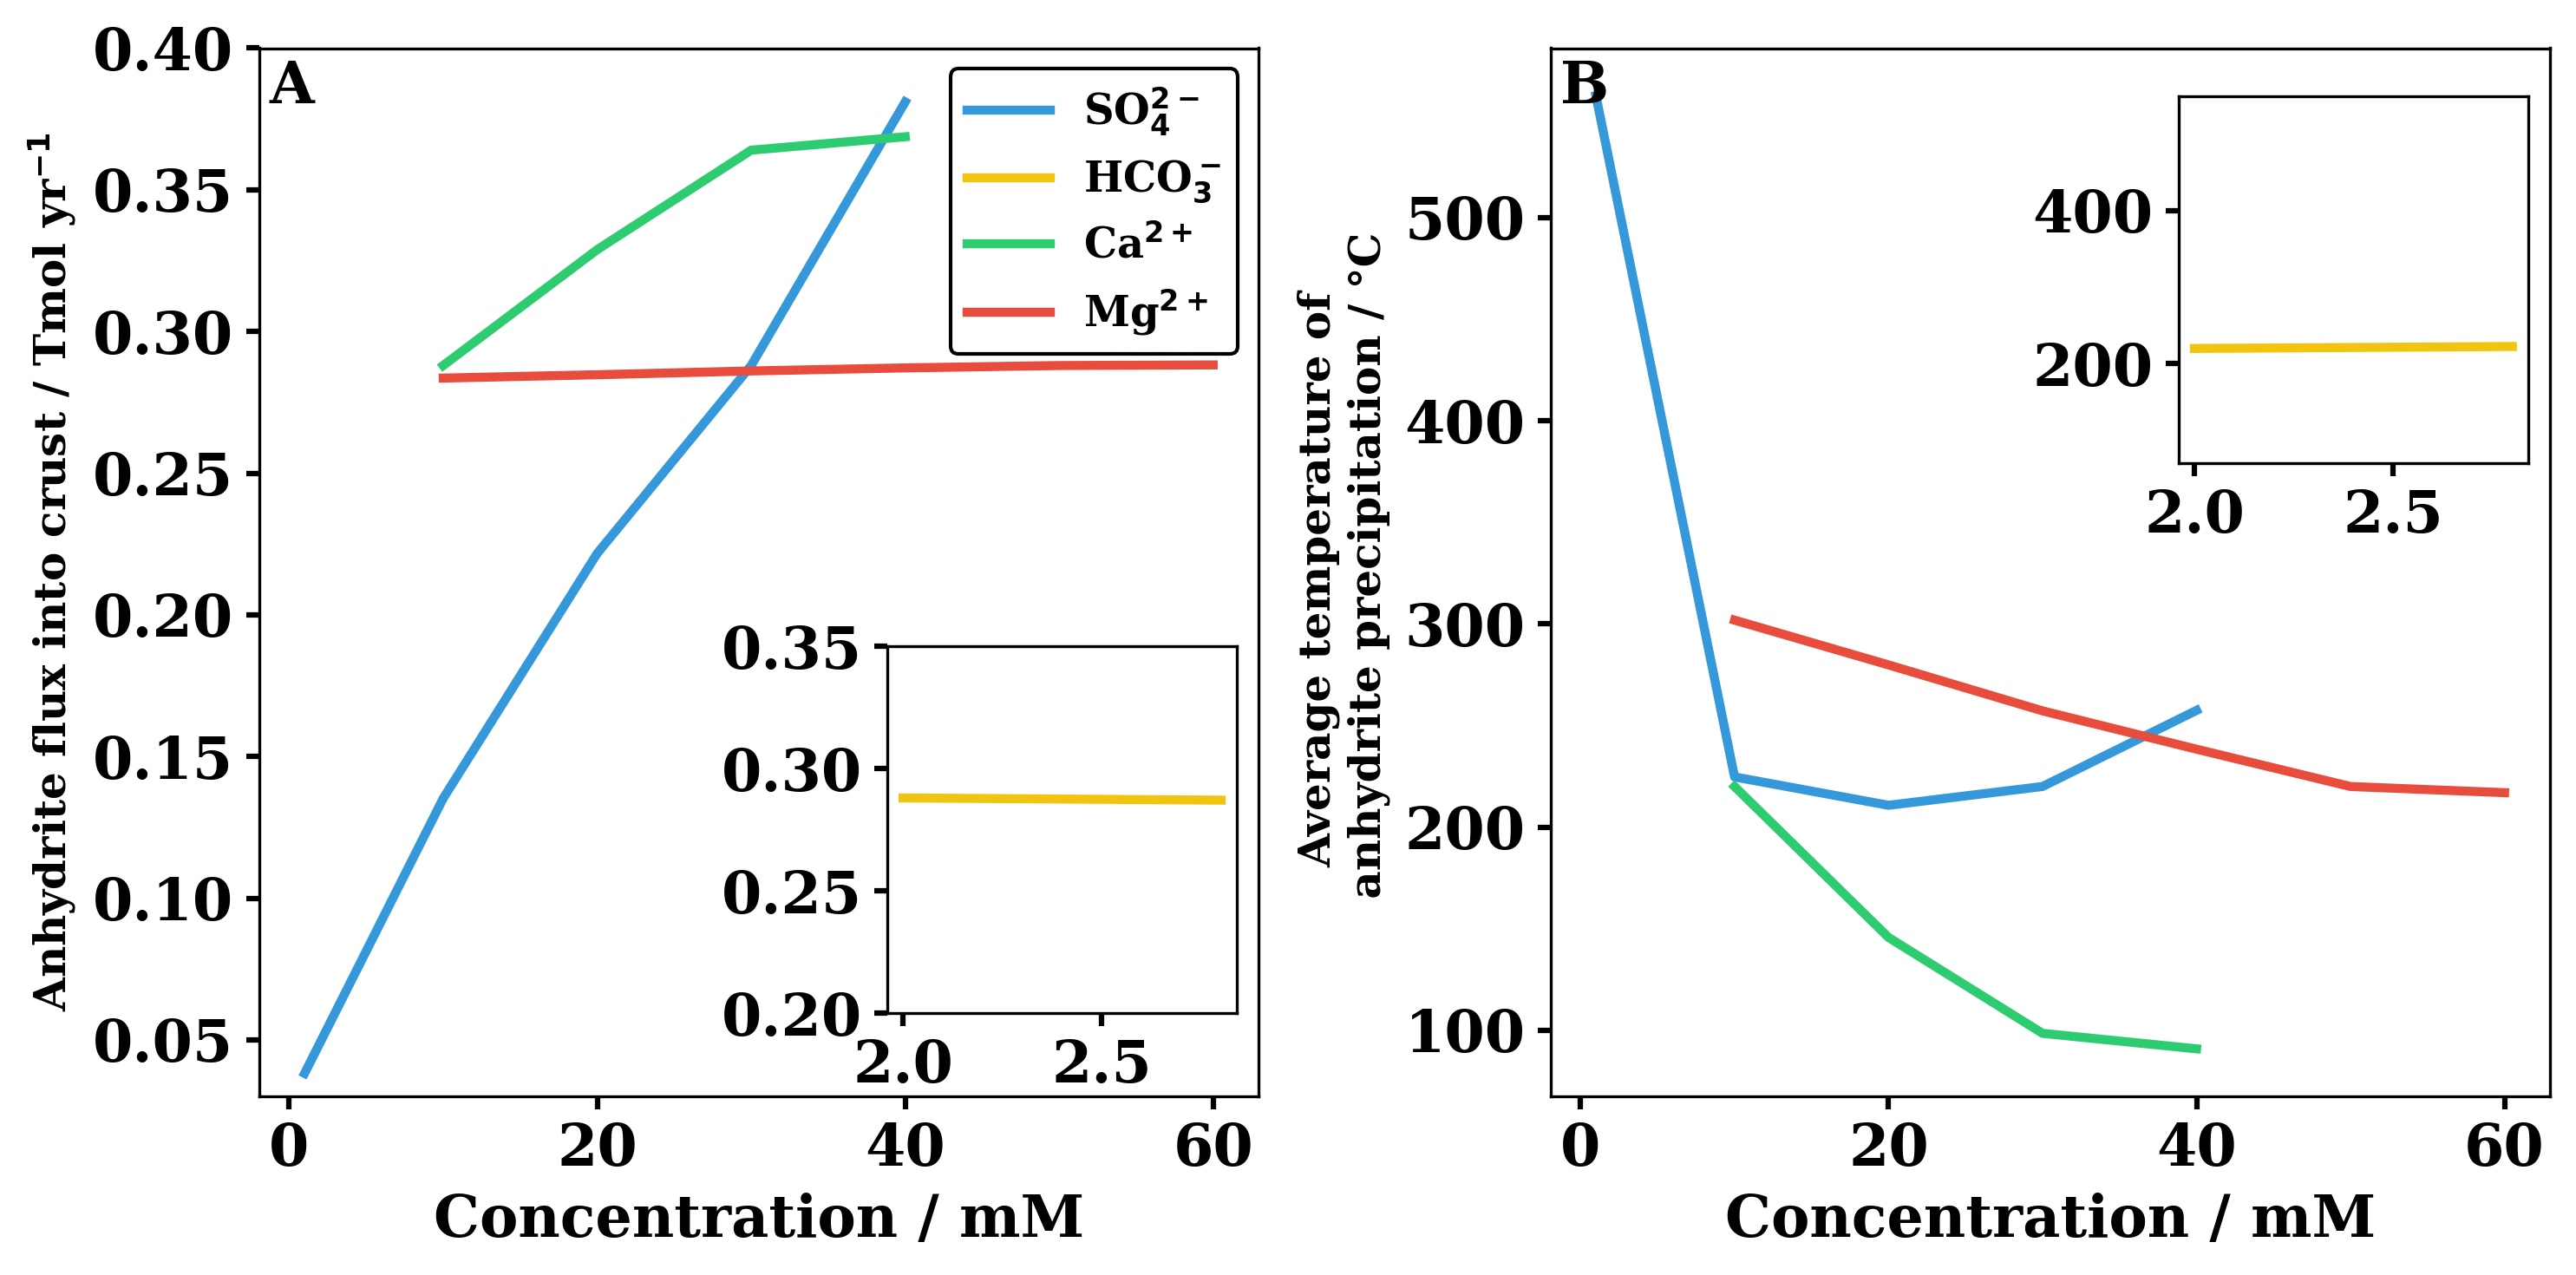

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('custom.mplstyle')
from cmcrameri import cm
import numpy as np
import copy
import string


# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()

fontsize = fig.bbox_inches.width * 1.2

# Add capital letter labels to the subplots
for i, axis in enumerate(ax):
    axis.text(0.01, 0.99, string.ascii_uppercase[i], transform=axis.transAxes,
              fontsize=16, fontweight='bold', va='top')

# Example data and parameters
leg_entries = ['SO$\mathbf{_4^{2-}}$', 'HCO$\mathbf{_3^-}$', 'Ca$\mathbf{^{2+}}$', 'Mg$\mathbf{^{2+}}$']
range_sets = [(10, 14), (15, 19), (6, 9), (0, 5)]
concentrations = [[1, 10, 20, 30, 40],  # SO4
                  [2.0, 2.2, 2.4, 2.6, 2.8],  # HCO3
                  [10, 20, 30, 40],  # Ca
                  [10, 20, 30, 40, 50, 60]]  # Mg
inset_axes = [None, None]
inset_axes[0] = is_ax(ax[0],
                    width="70%", # width = 30% of parent_bbox
                    height="70%", # height : 1 inch
                    bbox_to_anchor=(0.5, -0.05, 0.5, 0.5),
                    bbox_transform=ax[0].transAxes)

inset_axes[1] = is_ax(ax[1],
                    width="70%", # width = 30% of parent_bbox
                    height="70%", # height : 1 inch
                    bbox_to_anchor=(0.5, 0.475, 0.5, 0.5),
                    bbox_transform=ax[1].transAxes)


# Plot flux (dummy function for example)
plot_var = 'Anhydrite_VF'
plot_flux(ax[0], inset_axes[0], concentrations, pf_data, plot_var, range_sets, leg_entries)

custom_cycle = custom_color_cycler()
for conc_range, range_set, legend_entry in zip(concentrations, range_sets, leg_entries):
    if legend_entry == 'HCO$\mathbf{_3^-}$':
        color = next(custom_cycle)
        inset_axes[1].plot(conc_range, anhydrite_depth(pf_data.isel(file_number=slice(range_set[0], range_set[1] + 1))), label=legend_entry, color=color)
        ax[1].plot([], [], label=legend_entry, color=color)
    else:
        color = next(custom_cycle)
        ax[1].plot(conc_range, anhydrite_depth(pf_data.isel(file_number=slice(range_set[0], range_set[1] + 1))), label=legend_entry, color=color)
        print(f'For {legend_entry}, the values are {anhydrite_depth(pf_data.isel(file_number=slice(range_set[0], range_set[1] + 1)))}')

ax[0].set_ylabel('Anhydrite flux into crust / Tmol yr$^{-1}$', fontsize=fontsize)
ax[0].set_xlabel('Concentration / mM')
ax[0].set_ylim(0.03, 0.4)
ax[1].set_ylabel('Average temperature of \n anhydrite precipitation / °C', fontsize=fontsize)
ax[1].set_xlabel('Concentration / mM')
ax[0].legend(loc='upper right', fontsize=fontsize-0.5)


inset_axes[0].set_ylim(0.2, 0.35)
inset_axes[1].set_ylim(70, 550)

# Show and save the figure
fig.tight_layout()
fig.show()
fig.savefig('output/figure_5.png', dpi=300, transparent=True)



0.007523832696671146
0.007536536375352231
0.007545595729509913
0.007549160109783517
0.007551608211582877
0.007552790941002312
0.007551608211582877
0.01227387977789701
0.017259568772865164
0.0255831547123709
0.00925809368540388
0.007874866352007398
0.007540733911358037
0.007551608211582877
0.007599801008192198
0.007562663114082589
0.00752585580987688
0.007489041909734073
0.007451803565451546
0.0074133796463290635


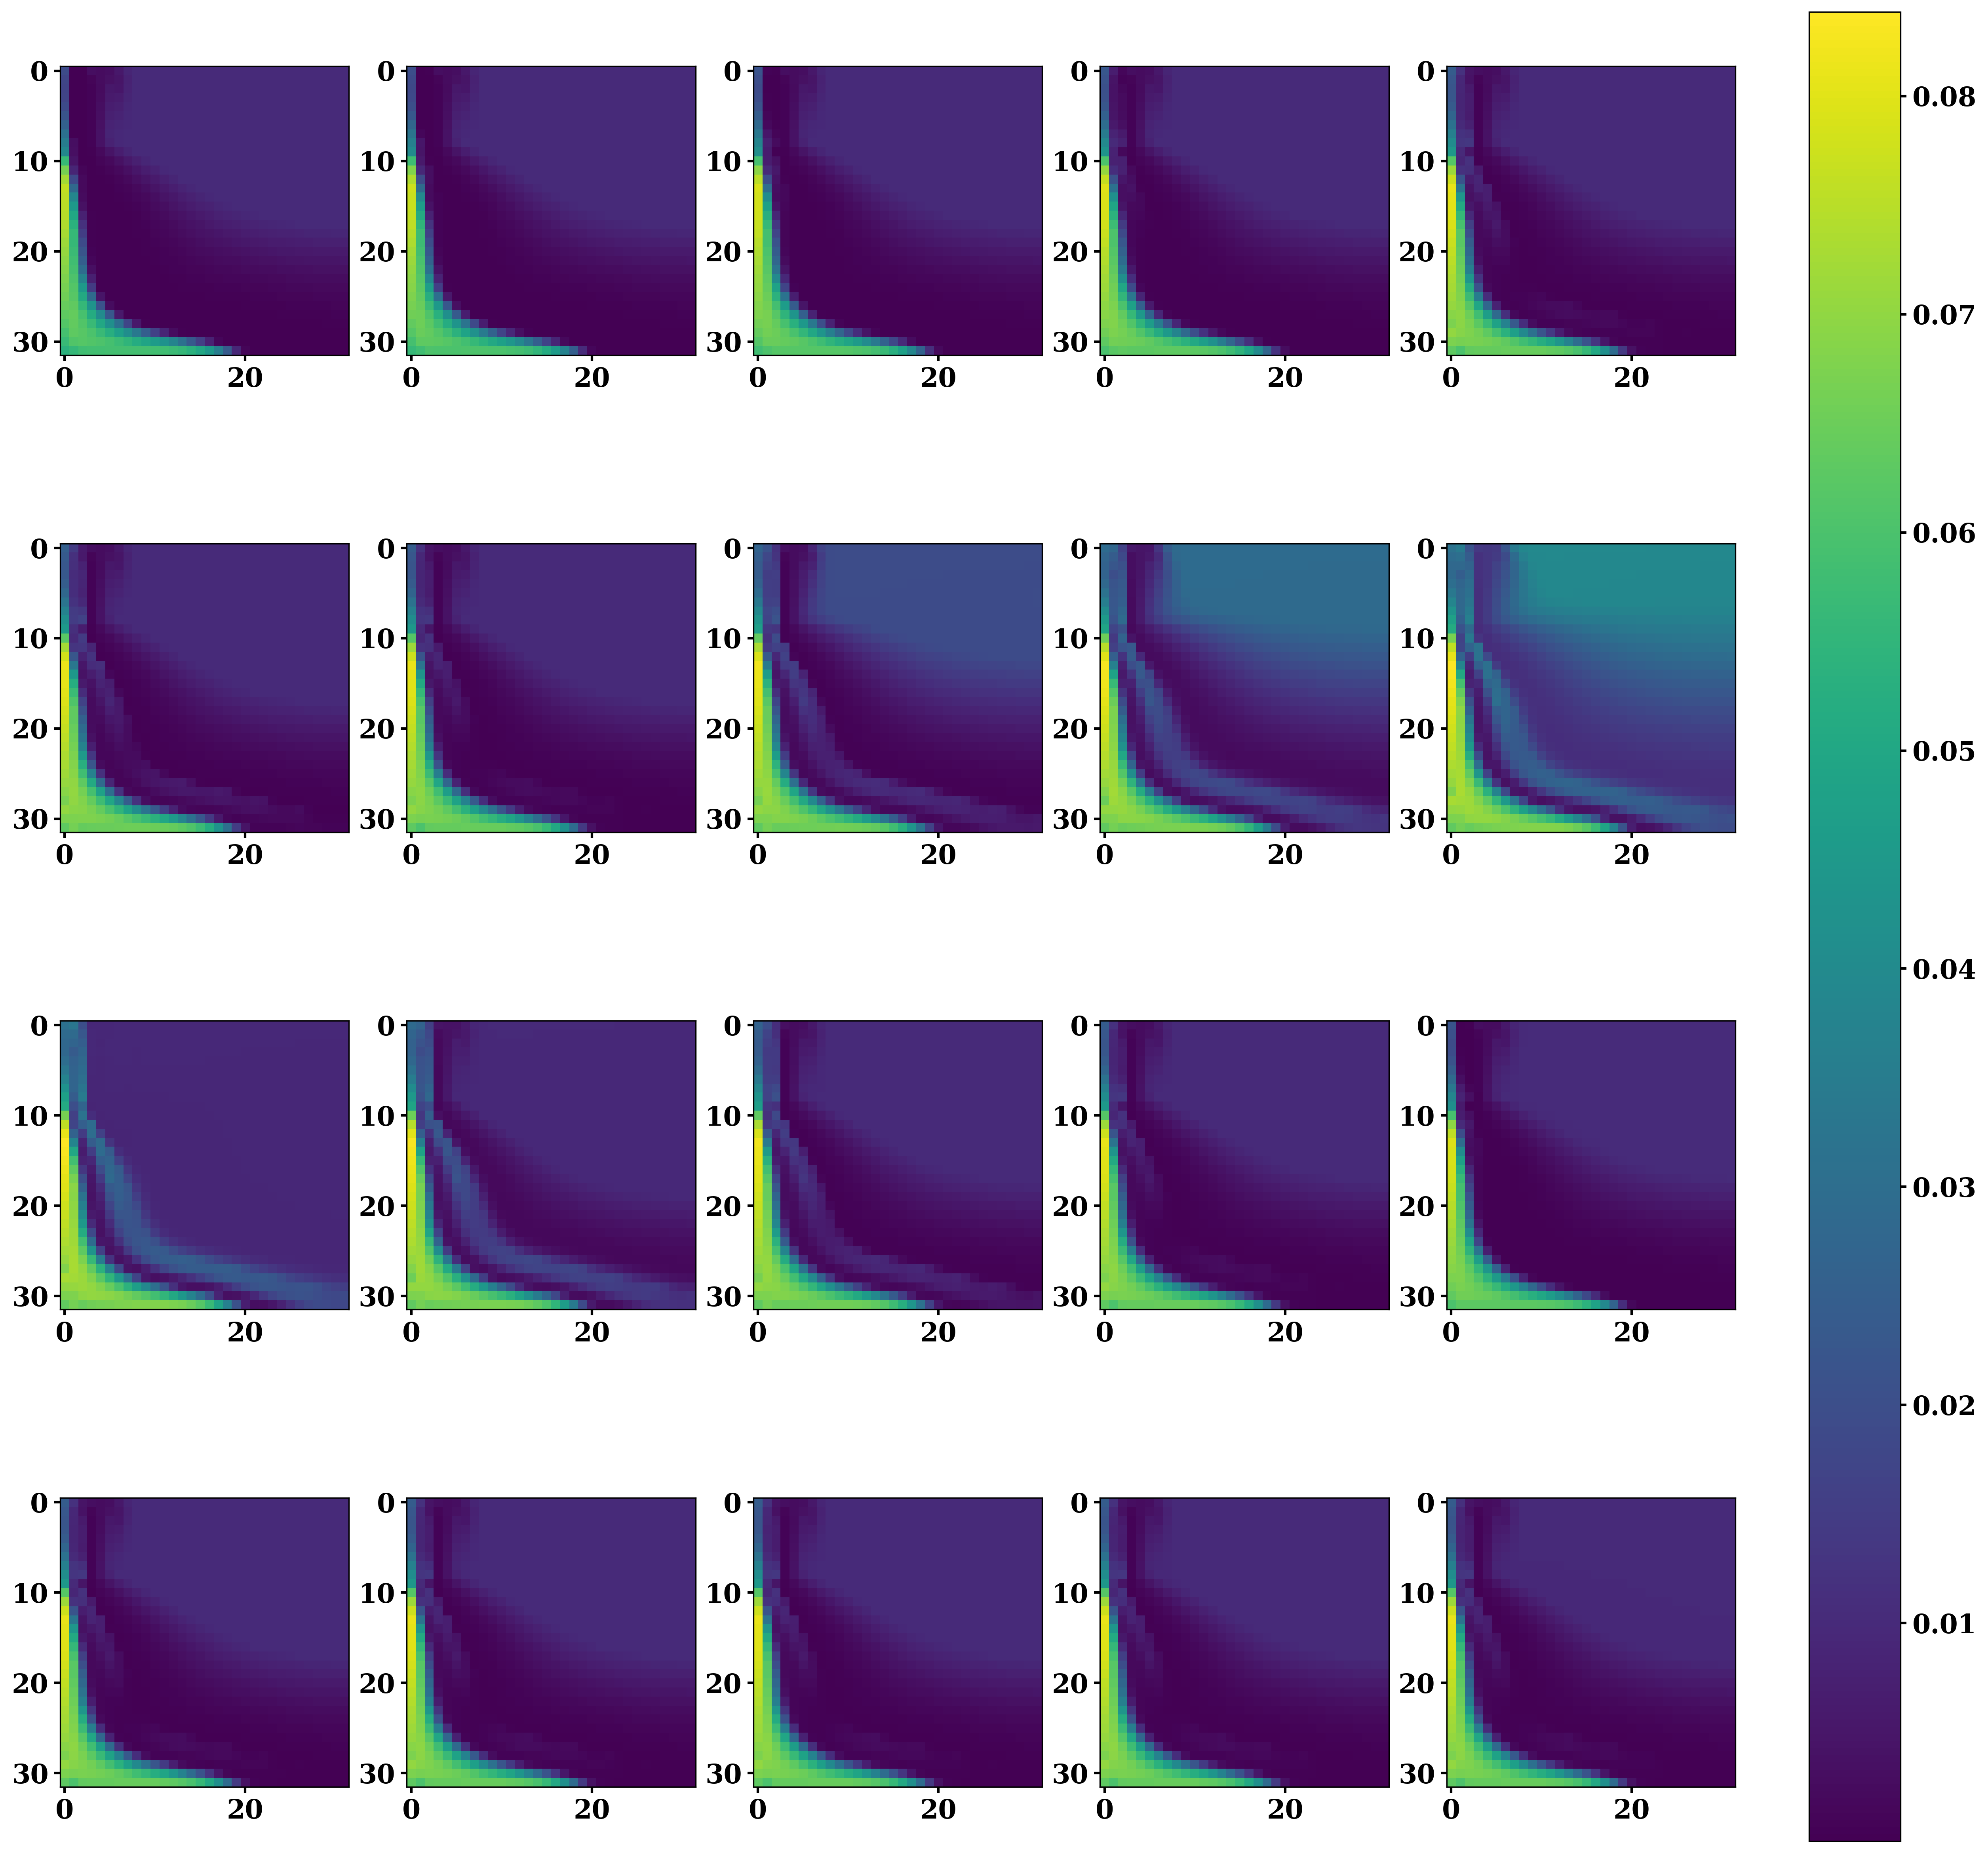

In [15]:

import numpy as np
import matplotlib.pyplot as plt

time=1000

dataset = pf_data
dimension = 'file_number'
plot_var = 'Total_Ca++'

# Calculate global min and max for consistent color scaling
all_data = np.concatenate([dataset.sel(file_number=coord, time=time)[plot_var].to_numpy().squeeze().flatten() 
                           for coord in dataset[dimension]])
vmin, vmax = np.min(all_data), np.max(all_data)

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
ax = ax.flatten()


for coord in dataset[dimension]:
    profile = dataset.sel(file_number=coord, time=time)[plot_var]
    condition = (dataset['Temperature'] >= 0) & (dataset['Temperature'] <= 150)
    print(dataset.sel(file_number=coord, time=1000)[plot_var].where(condition).mean().values)
    var = profile.to_numpy().squeeze()
    rotated_var = np.rot90(var)  # Rotate the array by 90 degrees anticlockwise
    ax[coord].imshow(rotated_var, cmap='viridis', vmin=vmin, vmax=vmax)  # Set consistent color scale

plt.colorbar(ax[0].images[0], ax=ax, orientation='vertical', fraction=0.05, pad=0.04)  # Add a colorbar